# Exploring Genomic Data

This notebook demonstrates working with genetic variant data stored as publicly accessible BigQuery datasets.

Specifically, we will work with the [Illumina Platinum Genomes](https://cloud.google.com/genomics/data/platinum-genomes) data. The source data was originally in [VCF format](http://vcftools.sourceforge.net/VCF-poster.pdf) which was then imported to [Google Genomics](https://cloud.google.com/genomics/) and exported to BigQuery.

If you want to explore more genomics samples, see https://github.com/googlegenomics/datalab-examples. You can import them into your Cloud Datalab instance by uploading them while on the notebook list page.

In [1]:
import gcp.bigquery as bq

## Variants

First, let's start with a little bit of genomics nomenclature:

 * **Variant**: A region of the genome that has been identified as differing from the reference genome.
 * **Non-variant Segment**: A region of the genome that matches the reference genome. 
 * **Reference Name**: The name of a reference segment of DNA, this is typically a chromosome, but may be other named regions from a reference genome.
 * **Reference Bases**: The A's, C's, T's, and G's comprising the DNA of the reference genome at the site of variation.
 * **Alternate Bases**: The A's, C's, T's, and G's comprising the DNA actually found at the site of variation for the sample(s) sequenced.
 * **SNP**: A [single nucleotide polymorphism](https://en.wikipedia.org/wiki/Single-nucleotide_polymorphism) is a DNA sequence variation in which a single nucleotide — A, T, C or G — in the genome (or other shared sequence) differs between members of a biological species or paired chromosomes.


In [2]:
variants = bq.Table('genomics-public-data:platinum_genomes.variants')
variants.length

688167235

Wow, that's a lot of records!  For a detailed description of the schema see [Understanding the BigQuery Variants Table Schema](https://cloud.google.com/genomics/v1/bigquery-variants-schema).

## SNPs

Next let's take a look at a few SNPs in our data.  As mentioned in the nomenclature, SNPs are a particular kind of genetic variant. Let's create an SQL statement that can list all variant records for a single base change:

In [3]:
%%sql
SELECT
  reference_name,
  start,
  reference_bases,
  alternate_bases,
FROM
  $variants
HAVING
  reference_bases IN ('A','C','G','T') AND
  alternate_bases IN ('A','C','G','T')
LIMIT 10

reference_name,start,reference_bases,alternate_bases
chr19,58656969,C,G
chr9,15915414,A,G
chr12,58858044,T,A
chr3,171945348,C,T
chr2,241924390,C,G
chr4,131191262,A,T
chr14,27725239,C,T
chr13,85383426,C,T
chr10,46737956,T,A
chr10,93349796,A,C


## Transition/Transversion Ratio

A SNP can be further classified as either a [transition](https://en.wikipedia.org/wiki/Transition_%28genetics%29) or a [transversion](https://en.wikipedia.org/wiki/Transversion).  The ratio of transitions to transversions (TiTv ratio) in humans is observed to be around 2.1, but this is not uniform across the genome.  Let's take a closer look by computing the TiTv ratio in contiguous regions of 100,000 base pairs.

In [4]:
window_size = 100000
# Some datasets use a 'chr' prefix in front of the chromosome name and others do not.
# So we need to allow both.
chromosome = ["1", "chr1"]

In [5]:
%%sql --module snps
windowsize = 0
chromosome = []

SELECT
  reference_name,
  reference_bases,
  alternate_bases,
  INTEGER(FLOOR(start / $windowsize)) AS window,
  CONCAT(reference_bases, CONCAT(STRING('->'), alternate_bases)) AS mutation,
  COUNT(alternate_bases) WITHIN RECORD AS num_alts,
FROM
  $variants
WHERE reference_name IN $chromosome
HAVING
  # Limit to bi-allelic SNP variants
  num_alts = 1
  AND reference_bases IN ('A','C','G','T')
  AND alternate_bases IN ('A','C','G','T')

We've updated the above query to include the "window" in which the SNP resides and added a new field called mutation.

In [6]:
bq.Query(snps, variants=variants, windowsize=window_size, chromosome=chromosome).sample()

reference_name,reference_bases,alternate_bases,window,mutation,num_alts
chr1,G,T,0,G->T,1
chr1,G,A,2100,G->A,1
chr1,C,T,2234,C->T,1
chr1,G,A,1135,G->A,1
chr1,T,G,2445,T->G,1


Next we group and classify the SNPs within their windows.

In [7]:
%%sql --module windows
SELECT
  reference_name,
  window,
  SUM(mutation IN ('A->G', 'G->A', 'C->T', 'T->C')) AS transitions,
  SUM(mutation IN ('A->C', 'C->A', 'G->T', 'T->G',
                   'A->T', 'T->A', 'C->G', 'G->C')) AS transversions,
  COUNT(mutation) AS num_variants_in_window
  FROM $snps
GROUP BY
  reference_name,
  window

In [8]:
bq.Query(windows, snps=snps, variants=variants, windowsize=window_size, 
         chromosome=chromosome).sample()

reference_name,window,transitions,transversions,num_variants_in_window
chr1,1815,164,100,264
chr1,2242,583,535,1118
chr1,155,474,255,729
chr1,1944,217,202,419
chr1,1435,1304,1063,2367


And finally, we compute the per-window TiTv ratio.

In [9]:
%%sql --module titv
SELECT
  reference_name,
  window * $windowsize AS window_start,
  transitions,
  transversions,
  transitions/transversions AS titv,
  num_variants_in_window,
FROM $windows
ORDER BY
    window_start

In [10]:
titvRatios = bq.Query(titv, windows=windows, snps=snps, chromosome=chromosome,
                      windowsize=window_size, variants=variants).to_dataframe()
titvRatios[:5]

,reference_name,window_start,transitions,transversions,titv,num_variants_in_window
0,chr1,0,293,198,1.479798,491
1,chr1,100000,147,76,1.934211,223
2,chr1,200000,64,61,1.049180,125
3,chr1,300000,2,11,0.181818,13
4,chr1,400000,30,14,2.142857,44


## Visualization

Now we can take the ratios and plot them by genomic position to see how the ratio can vary depending upon where it was computed within the chromosome.  By default this plot shows chromosome 1 with its gap in the center of the data corresponding to its [metacentric contromere](https://en.wikipedia.org/wiki/Centromere#Metacentric).

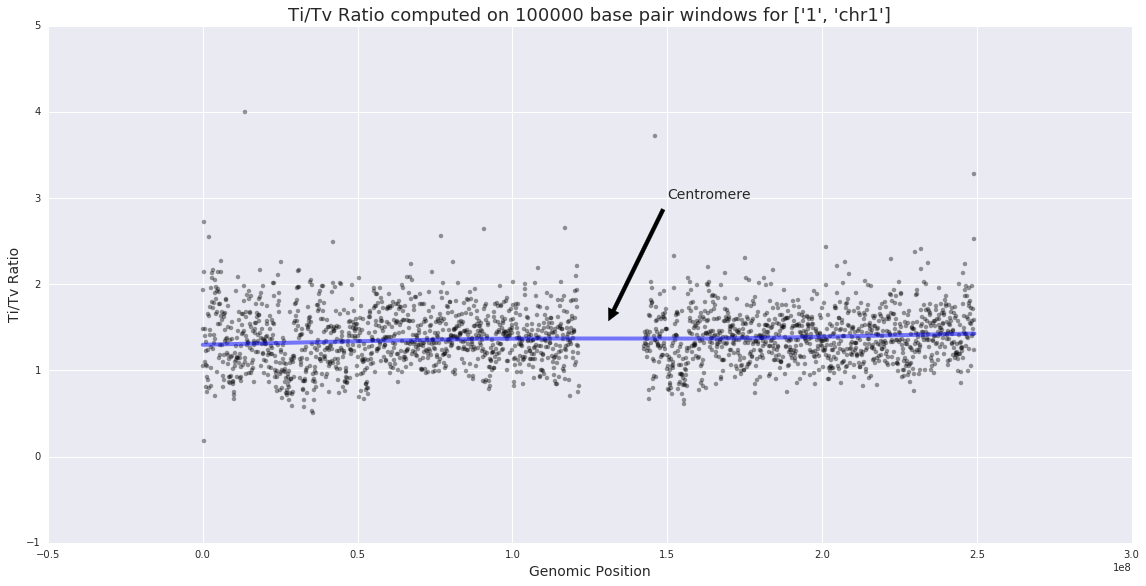

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.lmplot(x='window_start',
               y='titv',
               data = titvRatios,
               size = 8,
               aspect = 2,
               scatter_kws = { 'color': 'black', 'alpha': 0.4 },
               line_kws = { 'color': 'blue', 'alpha': 0.5, 'lw': 4 },
               lowess = True)
plt.xlabel('Genomic Position', fontsize = 14)  
plt.ylabel('Ti/Tv Ratio', fontsize = 14)
plt.title('Ti/Tv Ratio computed on %d base pair windows for %s' % (window_size, chromosome),
          fontsize = 18)
if chromosome == ['1', 'chr1']:
  plt.annotate('Centromere', xy = (1.3e8, 1.5), xytext = (1.5e8, 3), size = 14,
               arrowprops=dict(facecolor='black', shrink=0.05))